Topic : วิเคราะห์ความคุ้มค่าในการซื้อคอนโดใน กทม.

Dataset : ข้อมูลอสังหาแต่ละโครงการในประเทศไทยโดยแสดง ที่ตั้ง ราคา พื้นที่และค่าเช่า เป็นต้น โดยเก็บรวบรวมข้อมูลจาก baania ซึ่งเป็นเว็ปไซต์ประกาศขายและเช่าอสังหาริมทรัพย์

Question & Answer : 
- 1
    - Q : ถ้าต้องการซื้อคอนโดเพื่อปล่อยเช่าที่ไหนที่ผลตอบแทนสูงที่สุด?
    - A : เขตบางกะปิ เขตลาดพร้าว เขตลาดกระบัง ตามลำดับ
- 2
    - Q : พื้นที่ที่มีคอนโดราคาแพง มีความสะดวกในการเดินทางกว่า พื้นที่ที่มีคอนโดราคาถูก?
    - A : ใช่

Challenge : 
- ข้อมูลราคาค่าเช่าคอนโดที่ได้เป็นค่า median แยกตามเขต ซึ่งทำให้วิเคราะห์ผลตอบแทนจากค่าเช่ารายโครงการไม่ได้ต้องแยกตามเขตแทน
- ข้อมูลราคาค่าเช่าคอนโดมีไม่ครบทุกเขตใน กทม. ซึ่งเกิดจากบางเขตไม่มีคนลงประกาศเช่าใน baania จึงไม่มีข้อมูล
- แต่ละโครงการมีห้องหลายราคาทำให้ยากต่อการเลือกข้อมูลมาใช้ เพราะ ถ้าเลือกใช้ทุกราคาจะทำให้ค่า mean เพี้ยนเนื่องจากจำนวนที่มากเกินไป เนื่องจากหัวข้อเป็นวิเคราะห์ความคุ้มค่าของการซื้อคอนโด จึงเลือกใช้ห้องราคาต่ำที่สุดของแต่ละโครงการและตัดข้อมูลห้องที่เหลือในโครงการทิ้งไป

## Importing the libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'tahoma'

## Loading the dataset

In [87]:
unit = pd.read_csv('opendata_unittype.csv')
proj = pd.read_csv('opendata_project.csv')
liv_sc = pd.read_csv('opendata_living_score.csv')
eat_sc = pd.read_csv('opendata_eating_score.csv')
rent_p = pd.read_csv('opendata_median_price_rent.csv')

## Clean

### Project Data Clean

In [88]:
proj.head(3)

,row_number,project_id,name_en,name_th,propertytype_id,propertytype_name_en,propertytype_name_th,price_min,developer_id,developer_name_en,...,facility_meeting,facility_park,facility_playground,facility_pool,facility_security,date_created,date_finish,date_updated,source,url_project
0,5644.0,project_12591,Supalai Ville Sukhumvit-Srinakarin,ศุภาลัย วิลล์ สุขุมวิท-ศรีนครินทร์,3,Townhome,ทาวน์โฮม,1840000.0,developer_97,Supalai Public Company Limited,...,NaN,1.0,1.0,1.0,1.0,2017-12-15 14:39:29,2009-12-31 07:00:00,2020-12-04 10:44:32,baania,https://baania.com/th/project/ศุภาลัย-วิลล์-สุ...
1,20584.0,5ebb9b0742ad800019cd1546,Wararom Phetkasem 69,วรารมย์ เพชรเกษม 69,1,Detached House,บ้าน,2555000.0,developer_1158,Quality Houses Public Company Limited,...,NaN,NaN,NaN,NaN,1.0,2020-05-13 14:00:23,NaN,2022-01-07 18:00:10,baania,https://baania.com/th/project/วรารมย์-เพชรเกษม...
2,19570.0,project_5363,Baan Samretvill 1,บ้านสำเร็จวิลล์ 1,3,Townhome,ทาวน์โฮม,1100000.0,developer_10510,NaN,...,NaN,NaN,NaN,NaN,NaN,2017-03-28 10:25:41,1970-01-02 07:00:00,2020-12-04 10:38:03,baania,https://baania.com/th/project/บ้านสำเร็จวิลล์-...


In [89]:
proj_cd = proj.loc[proj['propertytype_name_en']=='Condo' ,['project_id','subdistrict_id', 'name_en', 'latitude','longitude', 'subdistrict_name_en', 'subdistrict_name_th', 'district_name_en', 'district_name_th', 'province_name_en', 'province_name_th']]
proj_cd_bk = proj_cd.loc[proj_cd['province_name_en']=='Bangkok']

In [90]:
proj_cd_bk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 8 to 23599
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   project_id           2557 non-null   object 
 1   subdistrict_id       2557 non-null   float64
 2   name_en              2557 non-null   object 
 3   latitude             2557 non-null   float64
 4   longitude            2557 non-null   float64
 5   subdistrict_name_en  2557 non-null   object 
 6   subdistrict_name_th  2557 non-null   object 
 7   district_name_en     2557 non-null   object 
 8   district_name_th     2557 non-null   object 
 9   province_name_en     2557 non-null   object 
 10  province_name_th     2557 non-null   object 
dtypes: float64(3), object(8)
memory usage: 239.7+ KB


In [91]:
proj_cd_bk.isna().sum()

project_id             0
subdistrict_id         0
name_en                0
latitude               0
longitude              0
subdistrict_name_en    0
subdistrict_name_th    0
district_name_en       0
district_name_th       0
province_name_en       0
province_name_th       0
dtype: int64

### Unit Data Clean

In [92]:
unit.head(3)

,row_number,unittype_id,project_id,name_th,propertytype_id,propertytype_name_en,propertytype_name_th,area_total_min_wa,area_usable_min,price_min,...,count_room_guest,count_room_kitchen,count_room_living,count_room_maid,count_room_storage,count_room_utility,date_created,date_updated,source,url_unittype
0,9921,unittype_32703,project_13900,S2,20000,Twin house,บ้านแฝด,NaN,120.0,4900000.0,...,NaN,1.0,1.0,NaN,NaN,NaN,2022-03-28 10:30:04,2022-03-28 10:24:51,baania,https://baania.com/th/project/บ้านสบาย-วิลเลจ-...
1,28994,unittype_9841,project_3367,A1-A5 Tower B Floor 2,2,Condo,คอนโด,NaN,29.0,897000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-12 13:20:52,2020-10-14 00:57:33,baania,https://baania.com/th/project/เดอะ-บรีส-คอนโดม...
2,13506,unittype_29776,project_12433,ทาวน์โฮมสามชั้น,3,Townhome,ทาวน์โฮม,NaN,NaN,2300000.0,...,NaN,1.0,NaN,NaN,NaN,NaN,2020-12-04 10:42:18,2020-10-14 19:17:28,baania,https://baania.com/th/project/นวลผกา-เฟส-1-124...


In [93]:
unit_cd = unit.loc[unit['propertytype_name_en']=='Condo',['project_id', 'area_usable_min', 'price_min', 'date_updated']]
unit_cd['pricesqm'] = round(unit_cd['price_min']/unit_cd['area_usable_min'], 2)
unit_cd['date_updated'] = pd.to_datetime(unit_cd['date_updated'])

In [94]:
unit_cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12711 entries, 1 to 42901
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   project_id       12711 non-null  object        
 1   area_usable_min  12372 non-null  float64       
 2   price_min        10906 non-null  float64       
 3   date_updated     12711 non-null  datetime64[ns]
 4   pricesqm         10802 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 595.8+ KB


In [95]:
unit_cd.isnull().sum()

project_id            0
area_usable_min     339
price_min          1805
date_updated          0
pricesqm           1909
dtype: int64

In [96]:
unit_cd.dropna(inplace=True)

In [97]:
# project_id นึงมีหลาย unit อยากได้ unit ในแต่ละ project_id ที่ราคาต่ำสุด

# เลือก unit ที่ราคาต่ำสุดใน project
unit_cd_new = unit_cd.loc[unit_cd['price_min'] == unit_cd.groupby('project_id').transform('min')['price_min'], :]

# drop duplicate ตัวที่ค่า area ซ้ำ
unit_cd_new = unit_cd_new.drop_duplicates(subset=['project_id','area_usable_min','price_min'])

# หาว่ายังมี project_id ที่ duplicate กันอยู่ไหม
unit_cd_new[unit_cd_new.duplicated(subset='project_id')].head()
 
# ปัญหาที่เจอ บาง project_id มี data null, duplicate, data เพี้ยน (price_min เท่่าแต่ area_min ต่างกัน) ใน column 'area_usable_min' 

,project_id,area_usable_min,price_min,date_updated,pricesqm
292,project_94,41.0,3590000.0,2021-05-11 10:19:04,87560.98
3552,project_94,33.0,3590000.0,2021-05-11 10:19:04,108787.88
10049,project_9468,42.0,990000.0,2022-07-01 14:04:06,23571.43
10442,project_953,85.0,1600000.0,2020-10-14 01:08:43,18823.53
10878,project_288,48.0,2400000.0,2020-11-17 15:22:32,50000.00


In [98]:
# drop ตัวที่ค่ามั่ว
lst = list(unit_cd_new[unit_cd_new.duplicated(subset='project_id')]['project_id'].unique())
unit_cd_new = unit_cd_new[~unit_cd_new['project_id'].isin(lst)]

### Living Score Data Clean

In [99]:
liv_sc.head(3)

,row_number,subdistrict_id,subdistrict_name_en,subdistrict_name_th,district_id,district_name_en,district_name_th,province_id,province_name_en,province_name_th,...,access_bus,access_train,access_total,drive_leisure,drive_public_service,drive_school,drive_shopping,drive_work,drive_total,source
0,204,4622,BANG PLA SOI,บางปลาสร้อย,4617,MUEANG CHON BURI,เมืองชลบุรี,4616,Chon Buri,ชลบุรี,...,0.0,0.0,0.0,96.0,100.0,100.0,100.0,100.0,99.0,baania
1,138,2861,CHO HO,จอหอ,2858,MUEANG NAKHON RATCHASIMA,เมืองนครราชสีมา,2857,Nakhon Ratchasima,นครราชสีมา,...,0.0,0.0,0.0,80.0,85.0,81.0,95.0,87.0,89.0,baania
2,553,3783,KHLONG TOEI,คลองเตย,3782,KHLONG TOEI,คลองเตย,3781,Bangkok,กรุงเทพมหานคร,...,100.0,94.0,99.0,100.0,75.0,100.0,100.0,99.0,97.0,baania


In [100]:
liv_sc['living_score'] = round((liv_sc['walk_total']+liv_sc['access_total']+liv_sc['drive_total'])/3,2)
liv_sc_bk = liv_sc.loc[liv_sc['province_name_en']=='Bangkok' ,['subdistrict_id','living_score']].reset_index(drop=True)

In [101]:
liv_sc_bk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subdistrict_id  161 non-null    int64  
 1   living_score    161 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.6 KB


In [102]:
liv_sc_bk.isna().sum()

subdistrict_id    0
living_score      0
dtype: int64

In [103]:
# duplicate subdistrict_id
liv_sc_bk[liv_sc_bk.duplicated('subdistrict_id')]

,subdistrict_id,living_score
87,3838,77.67
136,3931,88.00


In [104]:
# duplicate subdistrict_id but different living_score
liv_sc_bk[liv_sc_bk['subdistrict_id']==3838]

,subdistrict_id,living_score
72,3838,74.00
87,3838,77.67


In [105]:
liv_sc_bk = liv_sc_bk.groupby('subdistrict_id').agg('mean').reset_index()

### Eating Score Data Clean

In [106]:
eat_sc.head(3)

,row_number,subdistrict_id,subdistrict_name_en,subdistrict_name_th,district_id,district_name_en,district_name_th,province_id,province_name_en,province_name_th,eating_daytime,eating_daytime_price,eating_daytime_quality,eating_daytime_variety,eating_nighttime,eating_nighttime_price,eating_nighttime_quality,eating_nighttime_variety,source
0,191,3935,PAK KHLONG PHASI CHAROEN,ปากคลองภาษีเจริญ,3928,PHASI CHAROEN,ภาษีเจริญ,3781,Bangkok,กรุงเทพมหานคร,65.0,79.0,48.0,79.0,68.0,81.0,44.0,76.0,baania
1,85,3864,ANUSAWARI,อนุสาวรีย์,3862,BANG KHEN,บางเขน,3781,Bangkok,กรุงเทพมหานคร,62.0,85.0,40.0,69.0,61.0,81.0,35.0,67.0,baania
2,160,4660,NONG BON DAENG,หนองบอนแดง,4654,BAN BUENG,บ้านบึง,4616,Chon Buri,ชลบุรี,38.0,42.0,39.0,29.0,32.0,18.0,37.0,36.0,baania


In [107]:
eat_sc['eating_price_score'] = (eat_sc['eating_daytime_price']+eat_sc['eating_nighttime_price'])/2
eat_sc['eating_quality_score'] = (eat_sc['eating_daytime_quality']+eat_sc['eating_nighttime_quality'])/2
eat_sc_bk = eat_sc.loc[eat_sc['province_name_en']=='Bangkok',['subdistrict_id','eating_price_score','eating_quality_score']]

In [108]:
eat_sc_bk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 543
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subdistrict_id        161 non-null    int64  
 1   eating_price_score    161 non-null    float64
 2   eating_quality_score  161 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.0 KB


In [109]:
eat_sc_bk.isna().sum()

subdistrict_id          0
eating_price_score      0
eating_quality_score    0
dtype: int64

In [110]:
# duplicate subdistrict_id
eat_sc_bk[eat_sc_bk.duplicated('subdistrict_id')]

,subdistrict_id,eating_price_score,eating_quality_score
416,3931,81.5,46.0
485,3838,83.5,47.5


In [111]:
# duplicate subdistrict_id but different eating_score
eat_sc_bk[eat_sc_bk['subdistrict_id']==3931]

,subdistrict_id,eating_price_score,eating_quality_score
168,3931,79.0,47.5
416,3931,81.5,46.0


In [112]:
eat_sc_bk = eat_sc_bk.groupby('subdistrict_id').agg('mean').reset_index()

### Rent Price Data Clean

In [113]:
rent_p.head()

,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


In [114]:
# Filter the recent rent price
rent_p_recent = rent_p[(rent_p['transction_year']==rent_p['transction_year'].max())]
rent_p_recent = rent_p_recent[(rent_p_recent['transction_month']==rent_p_recent['transction_month'].max())]

In [115]:
rent_p_cd_bk = rent_p_recent.loc[(rent_p['listing_province_name_en'] == 'BANGKOK') & (rent_p_recent['project_propertytype_name_en'] == 'Condo'), ['listing_district_name_en','total_listing','median_rent_price_sqm']]

### Merge DF

In [116]:
# Merge DF
df_new = pd.merge(proj_cd_bk, unit_cd_new, on='project_id')
df_new = pd.merge(df_new, eat_sc_bk, on='subdistrict_id', how='left')
df_new = pd.merge(df_new, liv_sc_bk, on='subdistrict_id', how='left')
df_new = pd.merge(df_new, rent_p_cd_bk, left_on='district_name_en', right_on='listing_district_name_en', how='left')

In [117]:
df_new.head()

,project_id,subdistrict_id,name_en,latitude,longitude,subdistrict_name_en,subdistrict_name_th,district_name_en,district_name_th,province_name_en,...,area_usable_min,price_min,date_updated,pricesqm,eating_price_score,eating_quality_score,living_score,listing_district_name_en,total_listing,median_rent_price_sqm
0,project_16973,3906.0,Station One,13.743145,100.509101,POM PRAP,ป้อมปราบ,POM PRAP SATTRU PHAI,ป้อมปราบศัตรูพ่าย,Bangkok,...,26.94,2200000.0,2022-04-05 16:52:04,81662.95,65.0,63.5,99.00,NaN,NaN,NaN
1,project_15914,3899.0,La Maison Ruamrudee,13.738611,100.550494,LUMPHINI,ลุมพินี,PATHUM WAN,ปทุมวัน,Bangkok,...,130.00,10900000.0,2020-10-14 20:25:17,83846.15,45.0,71.5,98.67,PATHUM WAN,371.0,723.0
2,project_6619,3958.0,Poungsuwan Condo,13.827833,100.590692,LAT PHRAO,ลาดพร้าว,LAT PHRAO,ลาดพร้าว,Bangkok,...,30.00,450000.0,2020-10-16 16:39:32,15000.00,75.0,50.5,79.33,LAT PHRAO,17.0,329.0
3,project_17057,20615.0,The Nest Sukhumvit 64,13.684200,100.605139,PHRA HANONG TAI,พระโขนงใต้,PHRA KHANONG,พระโขนง,Bangkok,...,24.00,2400000.0,2021-03-19 11:32:54,100000.00,80.5,47.5,91.00,PHRA KHANONG,331.0,436.0
4,project_6205,3984.0,Watchara Condo Ville,13.909825,100.676658,O NGOEN,ออเงิน,SAI MAI,สายไหม,Bangkok,...,23.00,211000.0,2020-10-14 01:04:59,9173.91,84.0,29.0,62.33,NaN,NaN,NaN


In [118]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2367
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   project_id                2368 non-null   object        
 1   subdistrict_id            2368 non-null   float64       
 2   name_en                   2368 non-null   object        
 3   latitude                  2368 non-null   float64       
 4   longitude                 2368 non-null   float64       
 5   subdistrict_name_en       2368 non-null   object        
 6   subdistrict_name_th       2368 non-null   object        
 7   district_name_en          2368 non-null   object        
 8   district_name_th          2368 non-null   object        
 9   province_name_en          2368 non-null   object        
 10  province_name_th          2368 non-null   object        
 11  area_usable_min           2368 non-null   float64       
 12  price_min           

In [119]:
df_new.isnull().sum()

project_id                    0
subdistrict_id                0
name_en                       0
latitude                      0
longitude                     0
subdistrict_name_en           0
subdistrict_name_th           0
district_name_en              0
district_name_th              0
province_name_en              0
province_name_th              0
area_usable_min               0
price_min                     0
date_updated                  0
pricesqm                      0
eating_price_score            0
eating_quality_score          0
living_score                  0
listing_district_name_en    164
total_listing               164
median_rent_price_sqm       164
dtype: int64

In [120]:
df_new['project_id'].duplicated().sum()

0

In [121]:
df_new['livsc_per_pricesqm'] = df_new['living_score']/df_new['pricesqm']
df_new['eatingsc_qlt_per_price'] = df_new['eating_quality_score']/df_new['eating_price_score']
df_new['pricesqm_dct_mean'] = df_new.groupby('district_name_en')['pricesqm'].transform('mean')
df_new['pricesqm_dct_med'] = df_new.groupby('district_name_th')['pricesqm'].transform('median')
df_new['rent_return'] = (df_new['median_rent_price_sqm']/df_new['pricesqm_dct_mean'])*12*100

In [122]:
pro_count = proj_cd.groupby('province_name_th').size().to_frame('n_condos').sort_values(by='n_condos', ascending=False)
dct_count = df_new.groupby('district_name_th').size().to_frame('n_condos').sort_values(by='n_condos', ascending=False)
subdct_count = df_new.groupby('subdistrict_name_th').size().to_frame('n_condos').sort_values(by='n_condos', ascending=False)
dct_mean = df_new.groupby('district_name_th').apply('mean')
subdct_mean = df_new.groupby('subdistrict_name_th').apply('mean')

## EDA

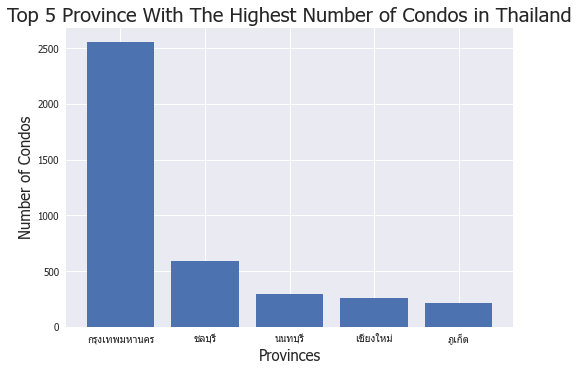

In [158]:
pro_count_top5 = pro_count.head()
plt.bar(pro_count_top5.index, pro_count_top5['n_condos'])
plt.title('Top 5 Province With The Highest Number of Condos in Thailand', fontsize=20)
plt.xlabel('Provinces', fontsize=15)
plt.ylabel('Number of Condos', fontsize=15)
plt.show()

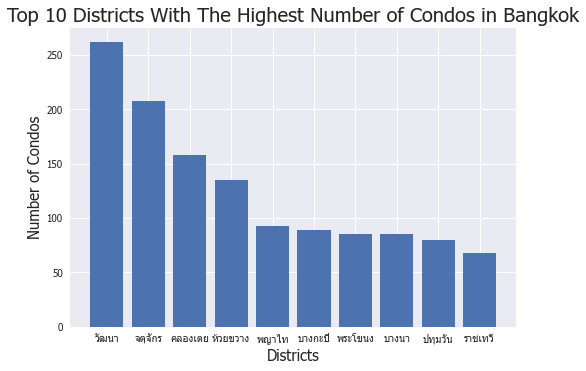

In [157]:
dct_count_top5 = dct_count.head(10)
plt.bar(dct_count_top5.index, dct_count_top5['n_condos'])
plt.title('Top 10 Districts With The Highest Number of Condos in Bangkok', fontsize=20)
plt.xlabel('Districts', fontsize=15)
plt.ylabel('Number of Condos', fontsize=15)
plt.show()

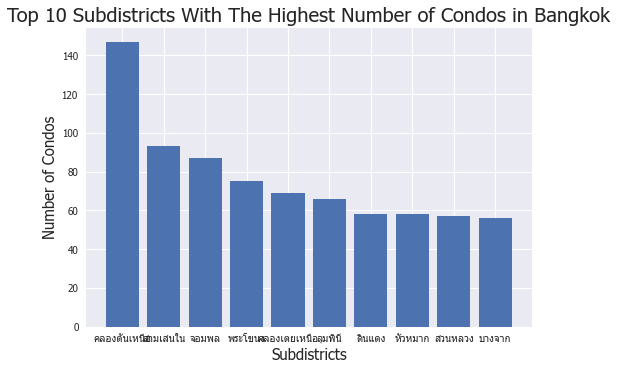

In [156]:
subdct_count_top5 = subdct_count.head(10)
plt.bar(subdct_count_top5.index, subdct_count_top5['n_condos'])
plt.title('Top 10 Subdistricts With The Highest Number of Condos in Bangkok', fontsize=20)
plt.xlabel('Subdistricts', fontsize=15)
plt.ylabel('Number of Condos', fontsize=15)
plt.show()

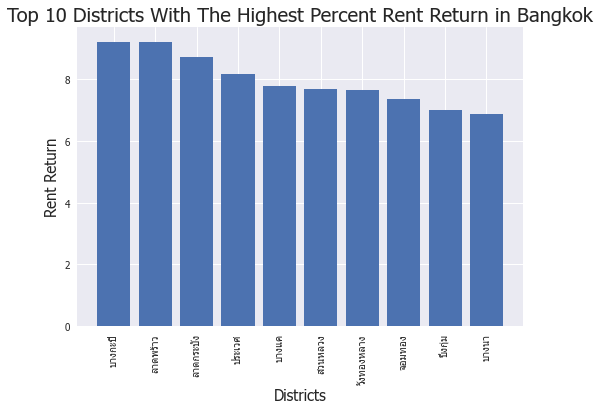

In [160]:
dct_rentreturn = dct_mean[['rent_return']].sort_values(by='rent_return', ascending=False).dropna().head(10)
plt.bar(dct_rentreturn.index, dct_rentreturn['rent_return'])
plt.tick_params(axis='x', rotation=90)
plt.title('Top 10 Districts With The Highest Percent Rent Return in Bangkok', fontsize=20)
plt.xlabel('Districts', fontsize=15)
plt.ylabel('Rent Return', fontsize=15)
plt.show()

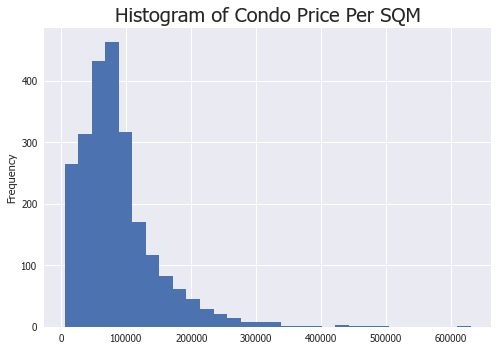

In [128]:
plt.title("Histogram of Condo Price Per SQM", fontsize='20')
df_new['pricesqm'].plot.hist(bins=30)
plt.show()

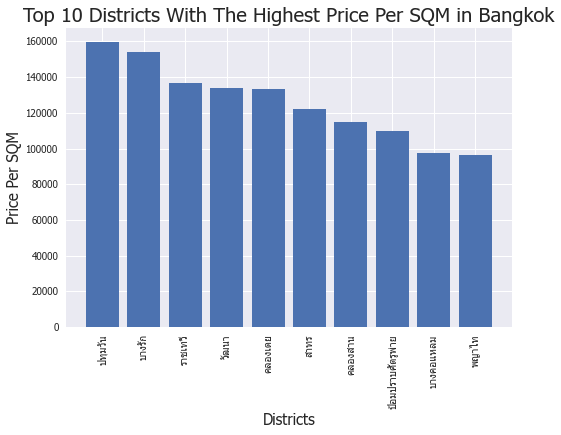

In [151]:
dct_pricesqm_mean = dct_mean[['pricesqm']].sort_values(by='pricesqm', ascending=False).head(10)
plt.bar(dct_pricesqm_mean.index, dct_pricesqm_mean['pricesqm'])
plt.tick_params(axis='x', rotation=90)
plt.title('Top 10 Districts With The Highest Mean Price Per SQM in Bangkok', fontsize=20)
plt.xlabel('Districts', fontsize=15)
plt.ylabel('Mean Price Per SQM', fontsize=15)
plt.show()

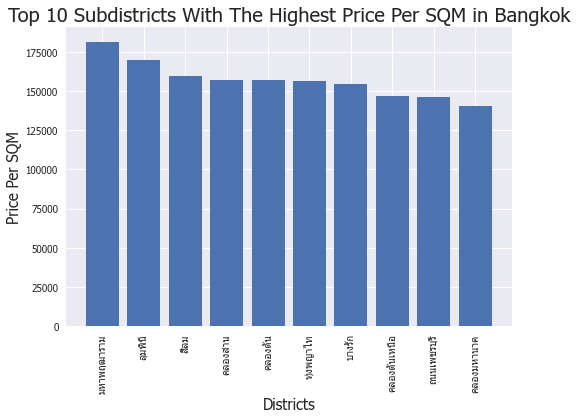

In [155]:
subdct_pricesqm_mean = subdct_mean[['pricesqm']].sort_values(by='pricesqm', ascending=False).head(10)
plt.bar(subdct_pricesqm_mean.index, subdct_pricesqm_mean['pricesqm'])
plt.tick_params(axis='x', rotation=90)
plt.title('Top 10 Subdistricts With The Highest Mean Price Per SQM in Bangkok', fontsize=20)
plt.xlabel('Districts', fontsize=15)
plt.ylabel('Mean Price Per SQM', fontsize=15)
plt.show()

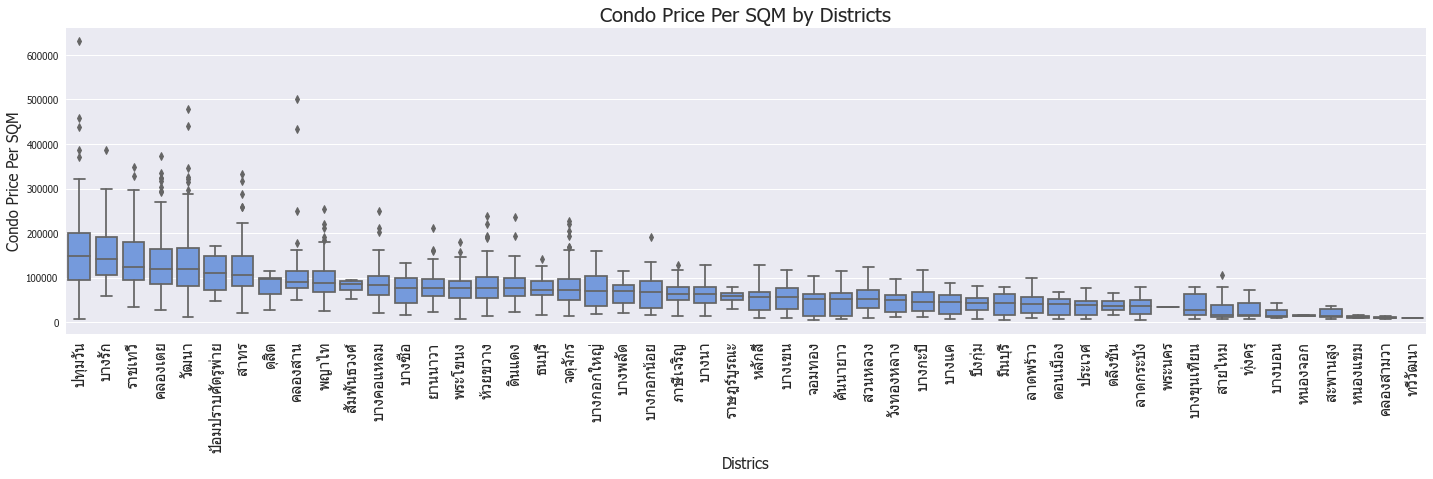

In [153]:
sns.catplot(data=df_new.sort_values(by='pricesqm_dct_med', ascending=False), kind='box', x='district_name_th', y='pricesqm', height=5, aspect=4, color='cornflowerblue').set_xticklabels(rotation=90, fontsize=15)
plt.title('Condo Price Per SQM by Districts', fontsize=20)
plt.xlabel('Districs', fontsize=15)
plt.ylabel('Condo Price Per SQM', fontsize=15)
plt.show()

## Map visualization

### Condos SQM Price by Locations

In [131]:
geometry = [Point(xy) for xy in zip(df_new['longitude'], df_new['latitude'])]
gdf = gpd.GeoDataFrame(df_new, geometry=geometry)

In [132]:
url = 'https://raw.githubusercontent.com/apisit/thailand.json/master/thailand.json'
th = gpd.read_file(url)

In [133]:
th.head(3)

,name,geometry
0,Mae Hong Son,"POLYGON ((98.08593 19.77316, 98.11135 19.77714..."
1,Chumphon,"POLYGON ((99.27258 10.95801, 99.27754 10.95902..."
2,Nakhon Si Thammarat,"POLYGON ((100.34246 7.93878, 100.33778 7.93789..."


In [134]:
bkk = th.loc[th['name']=='Bangkok Metropolis']

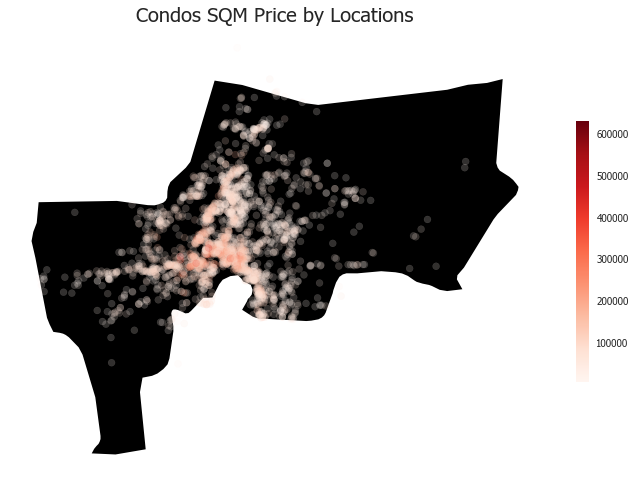

In [135]:
gdf.plot(ax=bkk.plot(figsize=(12,12), color='Black'), marker='o', cmap='Reds', column='pricesqm', alpha=0.2, legend=True, legend_kwds={'shrink': 0.4})
plt.title('Condos SQM Price by Locations', fontsize = 20)
plt.axis('off')
plt.show()

### Number of Condos by Districts

In [136]:
geo = gpd.read_file('district', encoding='cp874')

In [137]:
geo.head(3)

,OBJECTID,AREA,dcode,dname,dname_e,pcode,pname,num_male,num_female,num_school,num_hos,num_comm,num_temple,num_health,geometry
0,29,11804564.0,1025,เขตบางพลัด,Bang Phlat,10,กรุงเทพมหานคร,45904.0,53249.0,11.0,0.0,46.0,23.0,1.0,"POLYGON ((663924.794 1526162.057, 663895.856 1..."
1,30,16319268.0,1017,เขตห้วยขวาง,Huai Khwang,10,กรุงเทพมหานคร,35884.0,42323.0,3.0,0.0,25.0,3.0,2.0,"POLYGON ((671711.864 1526487.438, 671710.552 1..."
2,31,17075578.0,1045,เขตวังทองหลาง,Wang Thong Lang,10,กรุงเทพมหานคร,52758.0,61990.0,3.0,0.0,19.0,1.0,0.0,"POLYGON ((674358.118 1525633.939, 674369.430 1..."


In [138]:
geo = geo[['geometry','dname', 'dname_e']]
geo['dname'] = geo['dname'].replace(to_replace ='เขต', value = '', regex = True)
geo = pd.merge(geo, dct_count, left_on='dname', right_on=dct_count.index, how='left')
geo.fillna(0, inplace=True)

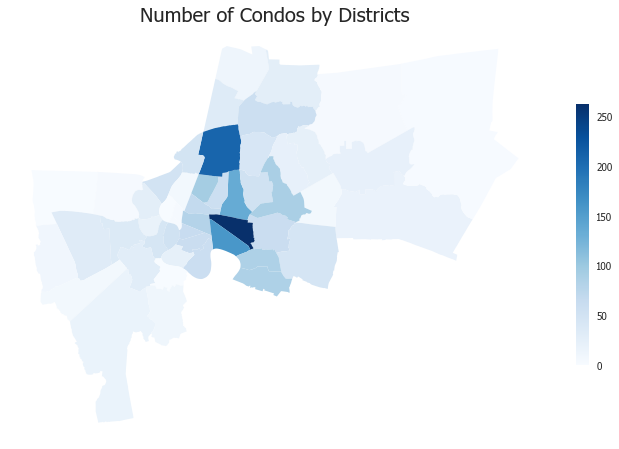

In [139]:
geo.plot(column='n_condos', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Number of Condos by Districts', fontsize = 20)
plt.axis('off')
plt.show()

### Condos Mean SQM Price by Districs

In [140]:
geo = pd.merge(geo, dct_mean[['pricesqm']], left_on='dname', right_on=dct_mean[['pricesqm']].index, how='left')

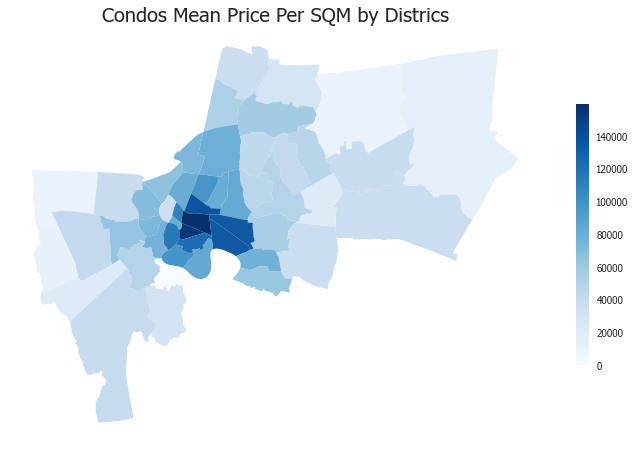

In [159]:
geo.plot(column='pricesqm', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Condos Mean Price Per SQM by Districs', fontsize = 20)
plt.axis('off')
plt.show()

### Condos Rent Return by Districts

In [142]:
geo = pd.merge(geo, dct_mean[['rent_return']], left_on='dname', right_on=dct_mean[['rent_return']].index, how='left')
geo.fillna(0, inplace=True)

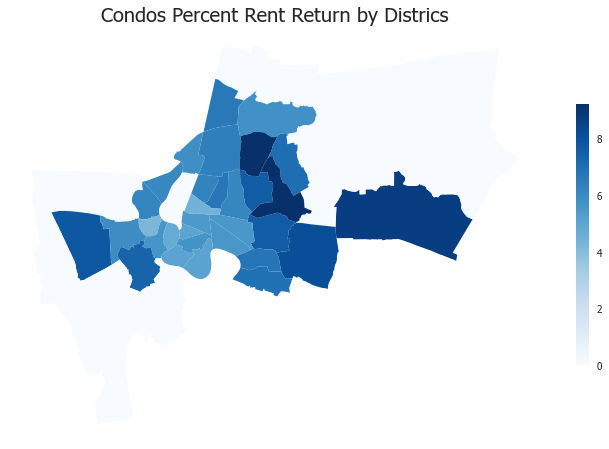

In [143]:
geo.plot(column='rent_return', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Condos Percent Rent Return by Districs', fontsize = 20)
plt.axis('off')
plt.show()

### Location Scores by Districs

In [144]:
geo = pd.merge(geo, dct_mean[['living_score']], left_on='dname', right_on=dct_mean[['living_score']].index, how='left')
geo = pd.merge(geo, dct_mean[['eating_price_score']], left_on='dname', right_on=dct_mean[['eating_price_score']].index, how='left')
geo = pd.merge(geo, dct_mean[['eating_quality_score']], left_on='dname', right_on=dct_mean[['eating_quality_score']].index, how='left')

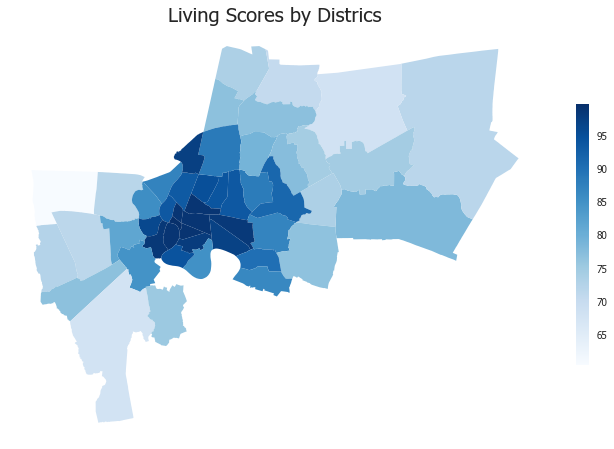

In [145]:
geo.plot(column='living_score', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Living Scores by Districs', fontsize = 20)
plt.axis('off')
plt.show()

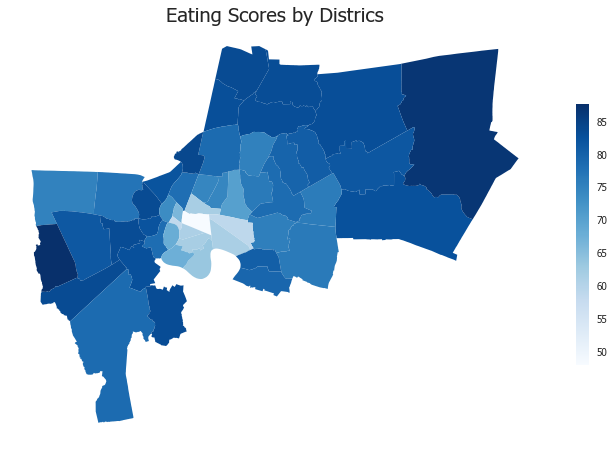

In [146]:
geo.plot(column='eating_price_score', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Eating Scores by Districs', fontsize = 20)
plt.axis('off')
plt.show()

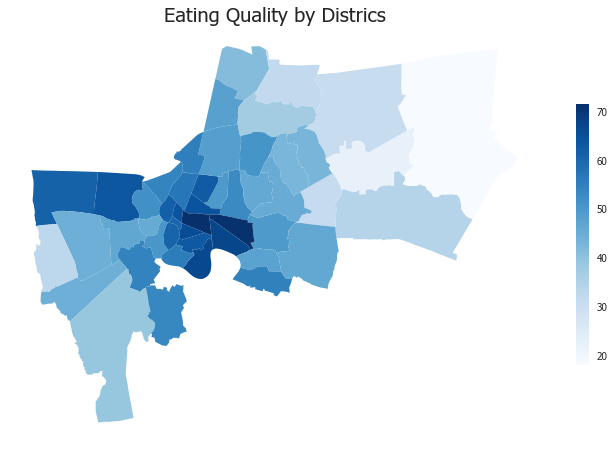

In [147]:
geo.plot(column='eating_quality_score', cmap='Blues', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.4})
plt.title('Eating Quality by Districs', fontsize = 20)
plt.axis('off')
plt.show()

## Location Scores

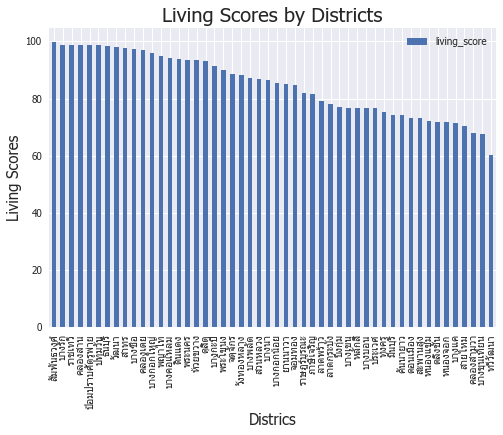

In [148]:
# คะแนน bar
dct_mean[['living_score']].sort_values(by='living_score', ascending=False).plot.bar()
plt.title('Living Scores by Districts', fontsize=20)
plt.ylabel('Living Scores', fontsize=15)
plt.xlabel('Districs', fontsize=15)
plt.show()

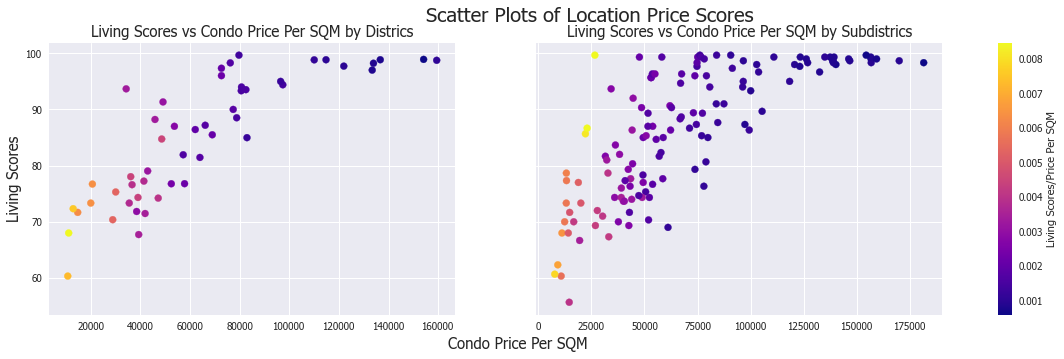

In [149]:
# living score ไปในทางเดียวกับ condominium sqm price แต่เมื่อเทียบสัดส่วน living score ที่ได้ต่อ condominium sqm price 
# พบว่าราคาต่ำจะมีสัดส่วนที่สูงกว่าราคาสูง สรุปได้ว่าทั้งสองค่าไปในทิศทางเดียวกันแต่มีปัจจัยอื่นที่ไม่มีข้อมูลเพิ่มขึ้นมาเมื่อราคาสูงถึงจุดหนึ่ง
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,5))
fig.suptitle('Scatter Plots of Location Price Scores', fontsize=20)

pcm1 = axs[0].scatter(dct_mean['pricesqm'], dct_mean['living_score'], c=dct_mean['livsc_per_pricesqm'], cmap='plasma')
axs[0].set_title('Living Scores vs Condo Mean Price Per SQM by Districs', fontsize=15)
axs[0].set_ylabel('Living Scores', fontsize=15)

pcm2 = axs[1].scatter(subdct_mean['pricesqm'], subdct_mean['living_score'], c=subdct_mean['livsc_per_pricesqm'], cmap='plasma')
axs[1].set_title('Living Scores vs Condo Mean Price Per SQM by Subdistrics', fontsize=15)
fig.colorbar(pcm2, ax=[axs[0], axs[1]], label = 'Living Scores/Price Per SQM')

fig.text(0.45, 0.03, 'Condo Price Per SQM', ha='center', fontsize=15)
plt.show()

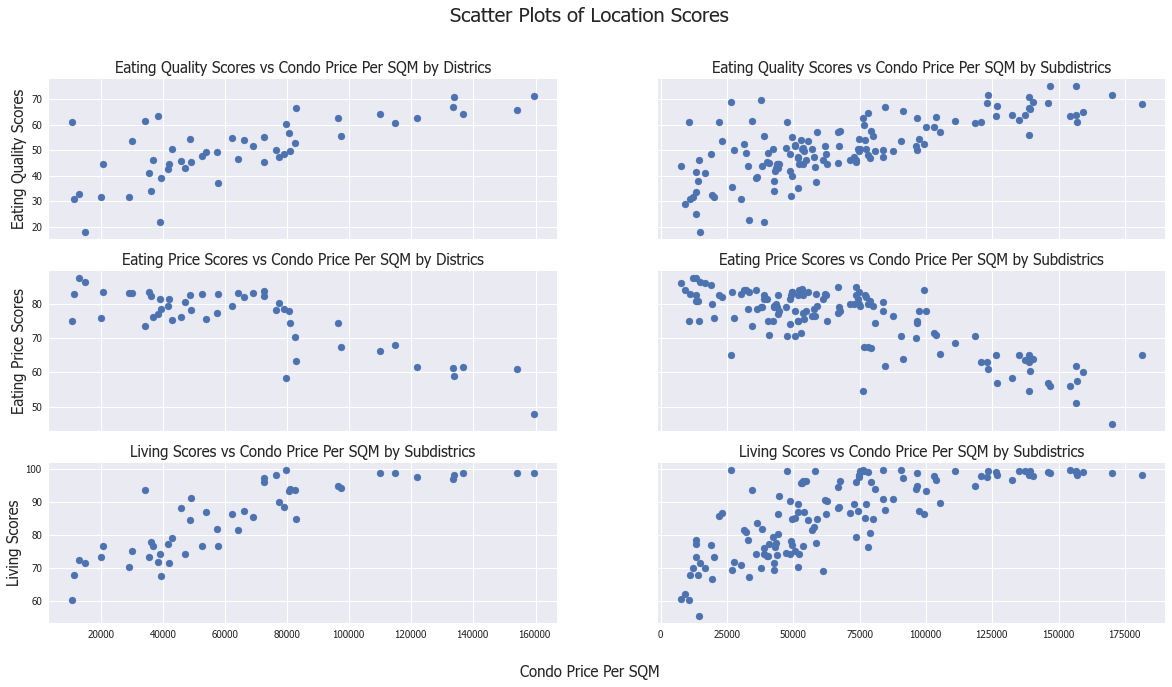

In [150]:
fig, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Scatter Plots of Location Scores', fontsize=20)

axs[0,0].scatter(dct_mean['pricesqm'], dct_mean['eating_quality_score'])
axs[0,0].set_title('Eating Quality Scores vs Condo Mean Price Per SQM by Districs', fontsize=15)
axs[0,0].set_ylabel('Eating Quality Scores', fontsize=15)

axs[0,1].scatter(subdct_mean['pricesqm'], subdct_mean['eating_quality_score'])
axs[0,1].set_title('Eating Quality Scores vs Condo Mean Price Per SQM by Subdistrics', fontsize=15)

axs[1,0].scatter(dct_mean['pricesqm'], dct_mean['eating_price_score'])
axs[1,0].set_title('Eating Price Scores vs Condo Mean Price Per SQM by Districs', fontsize=15)
axs[1,0].set_ylabel('Eating Price Scores', fontsize=15)

axs[1,1].scatter(subdct_mean['pricesqm'], subdct_mean['eating_price_score'])
axs[1,1].set_title('Eating Price Scores vs Condo Mean Price Per SQM by Subdistrics', fontsize=15)

axs[2,0].scatter(dct_mean['pricesqm'], dct_mean['living_score'])
axs[2,0].set_title('Living Scores vs Condo Mean Price Per SQM by Subdistrics', fontsize=15)
axs[2,0].set_ylabel('Living Scores', fontsize=15)

axs[2,1].scatter(subdct_mean['pricesqm'], subdct_mean['living_score'])
axs[2,1].set_title('Living Scores vs Condo Mean Price Per SQM by Subdistrics', fontsize=15)

fig.text(0.5, 0.05, 'Condo Price Per SQM', ha='center', fontsize=15)
plt.show()